In [5]:
#API
from flask import Flask, jsonify
import re
import sqlite3

from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from


# Install Libraries/Packages
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

#text
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


# Time
import time
import datetime
from datetime import datetime

# NLTK
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords

# EDA
from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ardhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ardhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Read dataset
df_data = pd.read_csv('data.csv', encoding='latin1')
df_data

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Check dataset info
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


# Functions

In [8]:
# Remove special text using regex
def remove_text_special(text):
    # Remove non-ascii characters from the string
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Remove newline
    text = text.replace("\\n", "")
    # Remove hashtags
    text = re.sub(r'#', '', text)
    # Remove single character
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # Remove number
    text = re.sub('[0-9]+', '', text)
    # Remove url
    text = re.sub(r"http\S+", "", text)
    # Strip space, " and ' from tweet
    text = text.strip(' "\'')
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove url uncomplete
    text = text.replace("http://", " ").replace("https://", " ")
    # Remove punctuation
    text = text.translate(str.maketrans("","",string.punctuation))
  
    return text

# Remove the word 'USER'
def remove_user(df, column_name):
    df[column_name] = df[column_name].str.replace(r'USER', '', regex=True)
    return df[column_name]

# Remove the word 'RT'
def remove_RT(df, column_name):
    df[column_name] = df[column_name].str.replace(r'RT', '', regex=True)
    return df[column_name]

# Lowercase the letters
def lowercase_letters(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df[column_name]

# Remove abusive words
def remove_abusive_words(df, column_name):
    # Load abusive words from the CSV file
    abusive_words_df = pd.read_csv('abusive.csv', encoding='latin-1')
    abusive_words = abusive_words_df['ABUSIVE'].tolist()

    # Convert specified column to string type
    df[column_name] = df[column_name].astype(str)

    # Replace or remove abusive words from the DataFrame
    for word in abusive_words:
        df[column_name] = df[column_name].str.replace(word, '')

    return df[column_name]

# Remove stopwords
def remove_stopwords(df, column_name):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    
    df[column_name] = df[column_name].apply(lambda x: " ".join(stopword.remove(x) for x in x.split()))
    return df[column_name]

# Tokenizing
def word_tokenize_wrapper(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

# Convert slang words
    # Read slang vocabulary dictionary
convert_slang_word = pd.read_csv("new_kamusalay.csv", encoding='latin-1')

    # Create a variable in the form of a dictionary that will store the results of convert slang word function
convert_slang_word_dict = {}

for index, row in convert_slang_word.iterrows():
    if row[0] not in convert_slang_word_dict:
        convert_slang_word_dict[row[0]] = row[1]

    # Function for convert slang word
def convert_slang_word_term(document):
    if isinstance(document, float):
        return document
    else:
        return [convert_slang_word_dict[term] if term in convert_slang_word_dict else term for term in document]
    
# Stemming
def stemming_process(df, column_name):
    # Record the start time
    start_time = datetime.now()

    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # stemming process
    df[column_name] = df[column_name].apply(lambda x: stemmer.stem(' '.join(x)) if isinstance(x, list) else stemmer.stem(x))
    return df[column_name]

    # Record the end time
    end_time = datetime.now()

    # Print the duration
    duration = end_time - start_time
    print("Stemming process took:", duration)

# Cleaning

In [9]:
# Cleanse the texts using functions
    
df_data['Tweet_cleaned'] = df_data['Tweet'].apply(remove_text_special)
    
df_data['Tweet_cleaned'] = remove_RT(df_data, 'Tweet_cleaned')
    
df_data['Tweet_cleaned'] = remove_user(df_data, 'Tweet_cleaned')
    
df_data['Tweet_cleaned'] = lowercase_letters(df_data, 'Tweet_cleaned')
    
df_data['Tweet_cleaned'] = remove_abusive_words(df_data,'Tweet_cleaned')
    
df_data['Tweet_cleaned'] = remove_stopwords(df_data,'Tweet_cleaned')
    
df_data['Tweet_cleaned'] = df_data['Tweet_cleaned'].apply(word_tokenize_wrapper)
    
df_data['Tweet_cleaned'] = df_data['Tweet_cleaned'].apply(convert_slang_word_term)
    
df_data['Tweet_cleaned'] = stemming_process(df_data, 'Tweet_cleaned')

In [10]:
df_data[['Tweet_cleaned', 'Tweet']].head(50)

,Tweet_cleaned,Tweet
0,di saat semua cowok usaha lacak perhati gue ka...,- disaat semua cowok berusaha melacak perhatia...
1,siapa telat beri tau kamu gue gaul cigax jifla...,RT USER: USER siapa yang telat ngasih tau elu?...
2,kadang aku pikir aku tetap percaya tuhan padah...,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,aku aku tau mata lihat mana aku,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,kaum ce kafir sudah lihat nya awal tambah haha,USER USER Kaum cebong kapir udah keliatan dong...
5,dan kawan kawan xfxfxxxfxfxxxfxfxx,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...
6,deklarasi pilih kepala daerah aman anti hoaks ...,deklarasi pilkada 2018 aman dan anti hoax warg...
7,gue baru saja selesai rewatch aldnoah zero pal...,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...
8,nah admin belanja satu port baik nak makan ais...,Nah admin belanja satu lagi port terbaik nak m...
9,enak lagi kalau sambil,USER Enak lg klo smbil ngewe'


In [11]:
# Check dataset info
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
 13  Tweet_cleaned  13169 non-null  object
dtypes: int64(12), object(2)
memory usage: 1.4+ MB


# Drop Null Data

In [12]:
# Checking if the dataset has a value of Null/NaN
is_NaN = df_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_data[row_has_NaN]
rows_with_NaN

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned


In [13]:
# Remove data that have NAN value in column text_clean
df_data.dropna(subset=['Tweet_cleaned'], inplace = True)
df_data

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_cleaned
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,di saat semua cowok usaha lacak perhati gue ka...
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,siapa telat beri tau kamu gue gaul cigax jifla...
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,kadang aku pikir aku tetap percaya tuhan padah...
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,aku aku tau mata lihat mana aku
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,kaum ce kafir sudah lihat nya awal tambah haha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0,jangan asal bicara ndasmu kamu yang kate anjing
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0,kasur mana enak
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0,hati hati glagi bosan duh xfxfxxaa
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0,bom real mudah deteksi bom kubur suatu lebih d...


In [14]:
# Check dataset info
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
 13  Tweet_cleaned  13169 non-null  object
dtypes: int64(12), object(2)
memory usage: 1.4+ MB


# Saving to SQL Database

In [15]:
conn = sqlite3.connect('cleansing.db')
cursor = conn.cursor()

df_data.to_sql(name='Tweets_notebook', con=conn, if_exists='replace', index=False)

# Mengecek tabel yang sudah kita buat sesuai apa belum
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

# mengecek value pada tabel classes dengan tampilan berupa dataframe
pd.read_sql_query('SELECT * FROM Tweets', conn)

# Kemudian kita dapat menutup connection ke database apabila database telah selesai terisi.
conn.close()

[('Tweets',), ('Tweets_notebook',)]


# EDA Analysis

In [16]:
hs_data = df_data[['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong']]

In [17]:
hs_sums = hs_data.sum(axis=0) 
hs_sums

HS               5561
Abusive          5043
HS_Individual    3575
HS_Group         1986
HS_Religion       793
HS_Race           566
HS_Physical       323
HS_Gender         306
HS_Other         3740
HS_Weak          3383
HS_Moderate      1705
HS_Strong         473
dtype: int64

In [18]:
hs_data.describe()

,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
count,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000,13169.000000
mean,0.422280,0.382945,0.271471,0.150809,0.060217,0.042980,0.024527,0.023236,0.284000,0.256891,0.129471,0.035918
std,0.493941,0.486123,0.444735,0.357876,0.237898,0.202819,0.154685,0.150659,0.450954,0.436935,0.335733,0.186092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


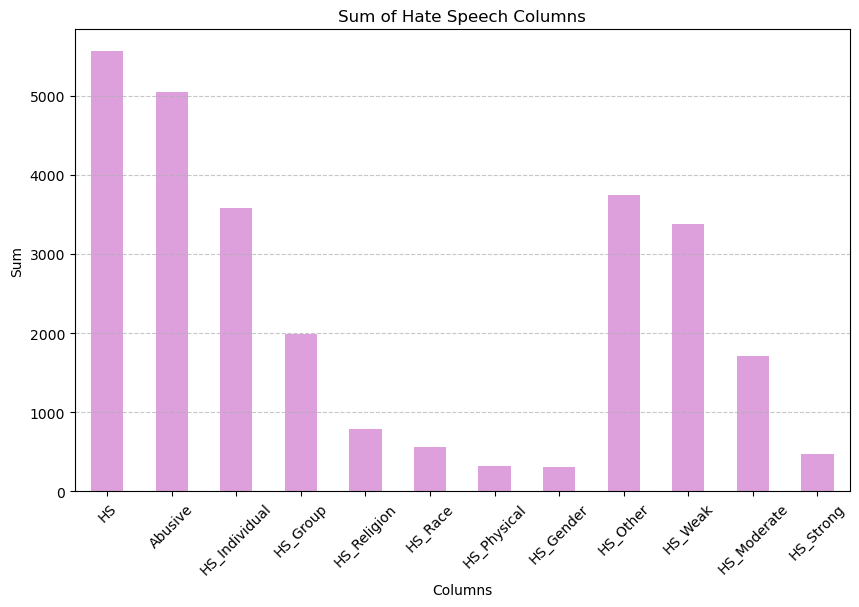

In [19]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
hs_sums.plot(kind='bar', color='plum')
plt.title('Sum of Hate Speech Columns')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

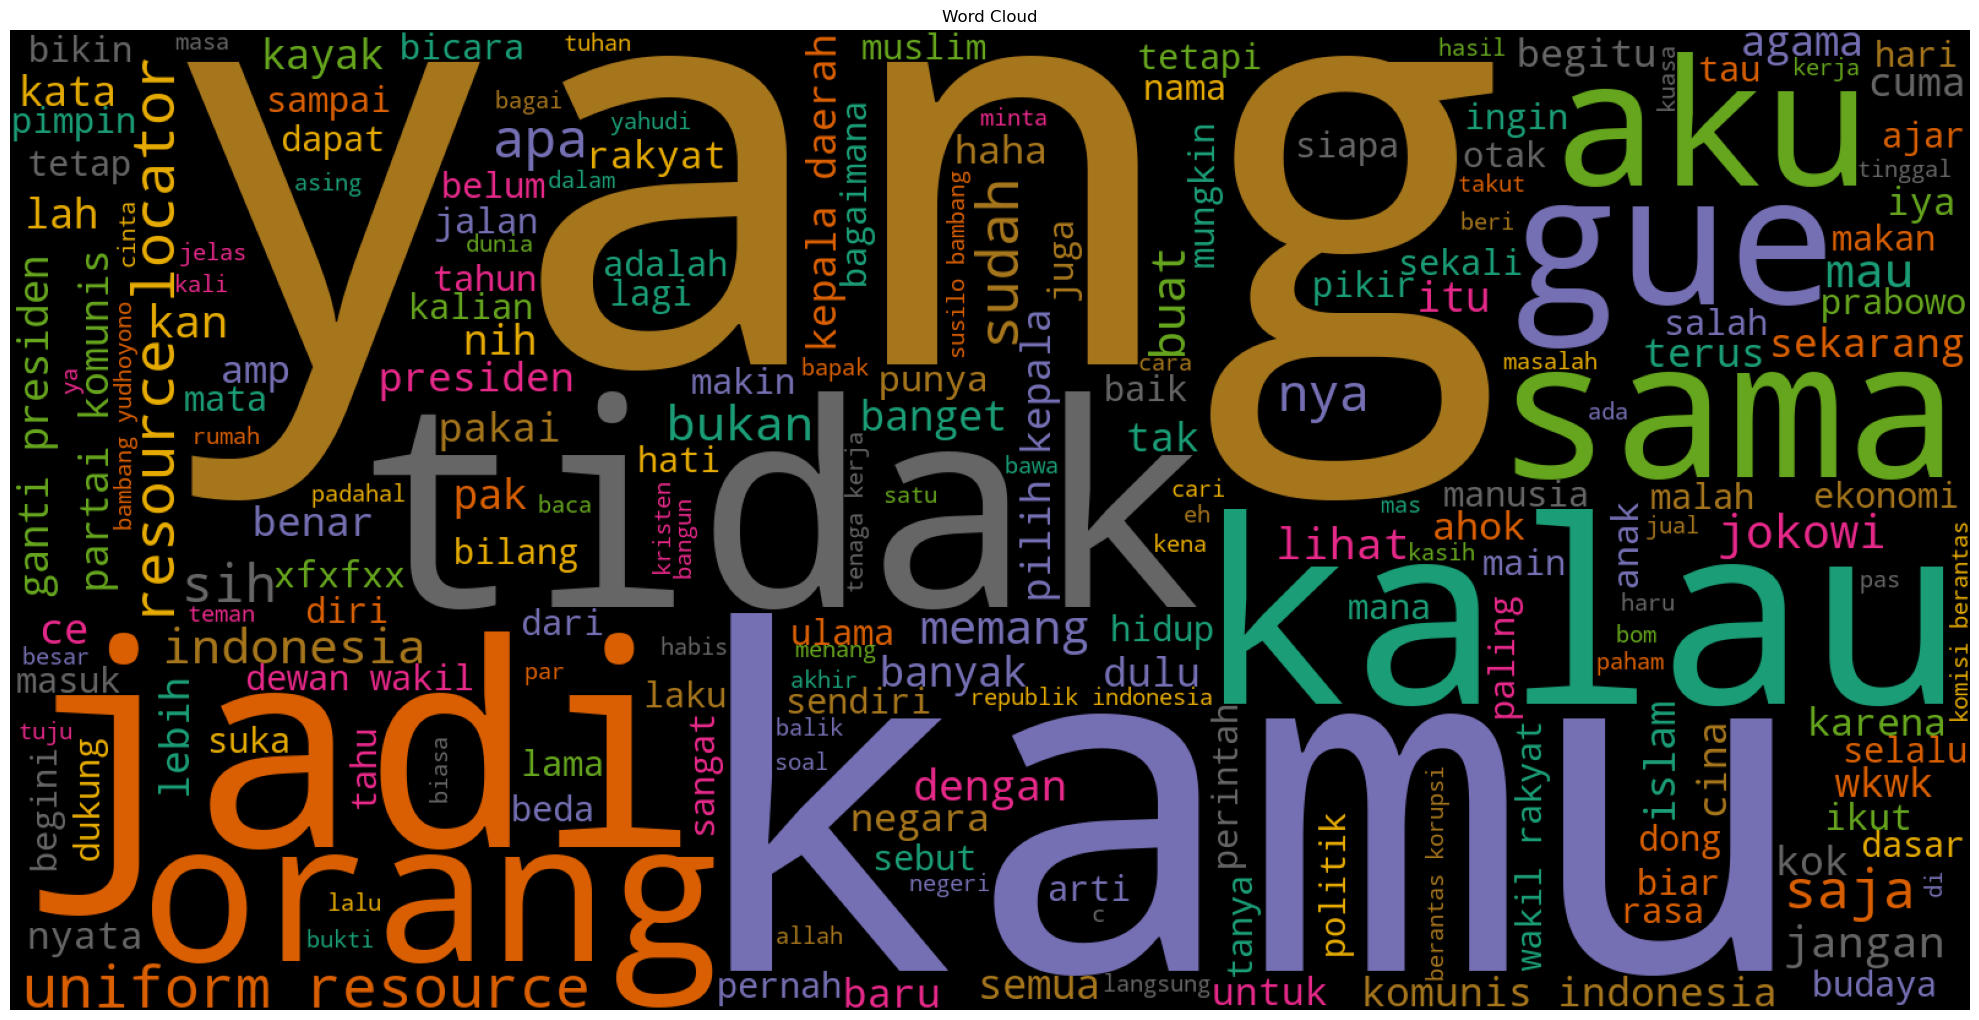

In [20]:
# Concatenate all tweets into a single text string
text = ' '.join(df_data['Tweet_cleaned'])

# Generate the word cloud
wordcloud = WordCloud(background_color='black', width=1600, height=800, colormap="Dark2").generate(text)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.title('Word Cloud')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

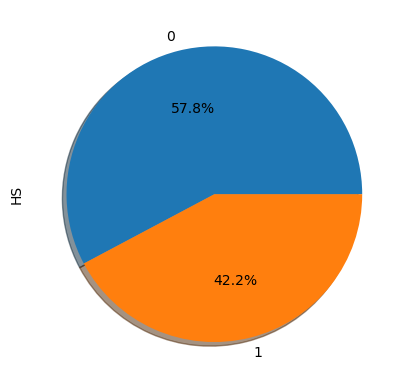

In [21]:
# Mencari perbandingan label/class
df_data['HS'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)
plt.show()

In [22]:
df_data['Tweet_length'] = df_data.Tweet.apply(lambda sent: len(sent.split()))

In [24]:
df_data['Tweet_Cleaned_length'] = df_data.Tweet_cleaned.apply(lambda sent: len(sent.split()))

In [33]:
df_data['total_char_Tweet'] = df_data.Tweet.apply(len)

In [34]:
df_data['total_char_Tweet_Cleaned'] = df_data.Tweet_cleaned.apply(len)

In [36]:
df_data[['Tweet','Tweet_length','total_char_Tweet','Tweet_cleaned','Tweet_Cleaned_length','total_char_Tweet_Cleaned']].head(50)

,Tweet,Tweet_length,total_char_Tweet,Tweet_cleaned,Tweet_Cleaned_length,total_char_Tweet_Cleaned
0,- disaat semua cowok berusaha melacak perhatia...,25,138,di saat semua cowok usaha lacak perhati gue ka...,20,113
1,RT USER: USER siapa yang telat ngasih tau elu?...,21,120,siapa telat beri tau kamu gue gaul cigax jifla...,14,71
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",37,254,kadang aku pikir aku tetap percaya tuhan padah...,31,187
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,14,75,aku aku tau mata lihat mana aku,7,31
4,USER USER Kaum cebong kapir udah keliatan dong...,14,89,kaum ce kafir sudah lihat nya awal tambah haha,9,46
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,6,73,dan kawan kawan xfxfxxxfxfxxxfxfxx,4,34
6,deklarasi pilkada 2018 aman dan anti hoax warg...,11,64,deklarasi pilih kepala daerah aman anti hoaks ...,11,68
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,20,129,gue baru saja selesai rewatch aldnoah zero pal...,20,131
8,Nah admin belanja satu lagi port terbaik nak m...,42,231,nah admin belanja satu port baik nak makan ais...,33,190
9,USER Enak lg klo smbil ngewe',6,29,enak lagi kalau sambil,4,22


C:\Users\ardhi\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Tweet_length', ylabel='total_char_Tweet'>

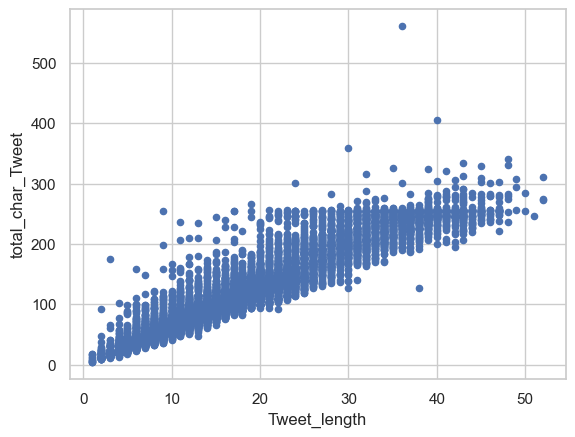

In [38]:
df_data.plot(x='Tweet_length',y='total_char_Tweet',kind = 'scatter')

<Axes: xlabel='Tweet_Cleaned_length', ylabel='total_char_Tweet_Cleaned'>

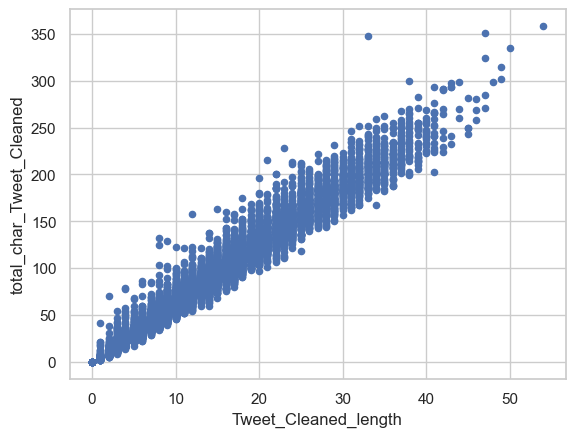

In [39]:
df_data.plot(x='Tweet_Cleaned_length',y='total_char_Tweet_Cleaned',kind = 'scatter')